# Porównanie algorytmów planowania z algorytmem genetycznym w problemie poszukiwania najkrótszej ścieżki w labiryncie z przeszkodami

---
## Wojciech Krawczyk, Mateusz Jastrzębiowski, Michał Gozdera, Paweł Frąckiewicz, Michał Klewicki

### Wstęp do Sztucznej Inteligencji, MiNI PW, 31.05.2021


Ustalenia projektowe:



1.   Problem reprezentujemy jako instancję klasy LabirynthProblem, a w niej pola:
*   labirynth - kwadratowa tablica numpy (0 - przeszkoda, 1 - brak przeszkody)
*   finish_position - tablica numpy 1x2 - pozycja mety
*   size - pomocnicza właściwość, która mówi, jakie wymiary ma labirynt (a jest kwadratowy więc jedna liczba)
2. Punkt startowy to zawsze (0,0), nie może tam być przeszkody.
3. Rozwiązanie reprezentujemy jako tablicę numpy 2D o wymiarach (m, 2), gdzie wiersze reprezentują kolejne kroki rozwiązania, a w kolumnach współrzędne danego kroku.



---




### Reprezentacja problemu


---




In [ ]:
import PIL
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from typing import List, Set, Dict, Tuple, Optional, Callable
from collections import namedtuple
import unittest
from operator import attrgetter
import sys
import time
import pandas as pd

In [ ]:
class Labirynth_Problem:
  starting_position = (0,0)

  #finish position - numpy array 1x2
  def __init__(self, labirynth: np.ndarray, finish_position: np.ndarray):
    self.labirynth = labirynth
    self.finish_position = finish_position
    self.size = len(labirynth[0])

In [ ]:
class Labirynth_Solver:
  #solution is mx2 numpy array, where m is the number of steps in the soulution
  #first column are x coordinates, second column - y coordinates
  def solve_problem(self, problem: Labirynth_Problem) -> np.ndarray:
    pass

In [ ]:
def generate_random_problem(size: int = 10, obstacle_rate: float = 0.2) -> Labirynth_Problem:
  temp = np.random.rand(size, size)
  labirynth = np.ones((size, size), dtype=int)
  labirynth[temp<obstacle_rate] = 0
  #start cannot contain obstacle
  labirynth[0,0] = 1
  finish_position = np.random.randint(0,size,(1,2))
  #finish cannot contain obstacle
  labirynth[finish_position[:,0],finish_position[:,1]] = 1
  return Labirynth_Problem(labirynth, finish_position)


In [ ]:
lab = generate_random_problem(100, 0.1)
lab.labirynth, lab.finish_position

(array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 0],
        ...,
        [1, 1, 1, ..., 0, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 0, 1, ..., 1, 1, 1]]), array([[19, 29]]))

In [ ]:
def plot_labirynth(labirynth_problem: Labirynth_Problem) -> None:
  plt.imshow(labirynth_problem.labirynth, cmap = "gray")
  plt.plot(labirynth_problem.finish_position[0,1],
           labirynth_problem.finish_position[0,0],
           "r.")
  plt.yticks([])
  plt.xticks([])

def plot_path(path: np.ndarray) -> None:
  plt.plot(path[:,1], path[:,0])

def plot_population(population) -> None:
  for i in range(len(population.members)):
    curr_path = population.members[i].get_solution()
    plt.plot(curr_path[:,1], curr_path[:,0])

In [ ]:
pth = np.zeros((100,2))
pth[:,0] = np.arange(0,100)
pth[:,1] = np.arange(0,100)

[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 0]
 [1 0 0 1 1 1 0 1 1 1]
 [1 0 1 0 0 1 1 0 1 1]
 [1 1 1 0 1 1 0 1 1 0]
 [1 1 0 1 1 1 0 1 1 0]
 [1 1 1 1 0 1 0 1 1 1]
 [1 1 0 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 1 0]]
[[4 7]]


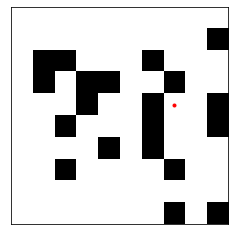

In [ ]:
lab = generate_random_problem(obstacle_rate=0.2)
plot_labirynth(lab)
print(lab.labirynth)
print(lab.finish_position)

### Algorytmy planowania

---


Algorytm Dijkstry

In [ ]:
class Tile:
    def __init__(self, x, y, previous=None):
        self.position = (x, y)
        self.previous = previous
        self.x = x
        self.y = y

    value = sys.maxsize

    def __eq__(self, other):
        return self.position == other.position


class DijkstraSolver(Labirynth_Solver):
    def __init__(self):
        pass

    def solve_problem(self, problem: Labirynth_Problem) -> np.ndarray:
        rows = problem.size
        columns = problem.size
        labirynth = problem.labirynth
        start = Tile(0, 0)
        destination = Tile(problem.finish_position[:, 0], problem.finish_position[:, 1])
        destination.value = 0
        success_flag = False
        openQueue = [destination]
        closed = np.zeros((rows, columns), dtype=int)
        while len(openQueue) > 0:
            openQueue.sort(key=lambda tile: tile.value, reverse=True)
            current_tile = openQueue.pop()
            closed[(current_tile.x, current_tile.y)] = 1
            if current_tile.position == start.position:  # is finish?
                path = []
                while current_tile != destination:
                    path.append(current_tile)
                    current_tile = current_tile.previous
                path.append(destination)
                solution = np.empty((len(path), 2), dtype=np.int32)
                for x in range(len(path)):
                    solution[x, 0] = path[x].x
                    solution[x, 1] = path[x].y
                return solution
                break
            else:  #  add all neighbours to open and add current to closed 
                (x, y) = current_tile.position
                to_add = []
                if x-1 >= 0:
                    if closed[(x - 1, y)] == 0 and labirynth[(x - 1, y)] == 1:
                        to_add.append(Tile(x - 1, y, current_tile))
                if x+1 < columns:
                    if closed[(x + 1, y)] == 0 and labirynth[(x + 1, y)] == 1:
                        to_add.append((Tile(x + 1, y, current_tile)))
                if y-1 >= 0:
                    if closed[(x, y - 1)] == 0 and labirynth[(x, y - 1)] == 1:
                        to_add.append(Tile(x, y - 1, current_tile))
                if y+1 < rows:
                    if closed[(x, y + 1)] == 0 and labirynth[(x, y + 1)] == 1:
                        to_add.append((Tile(x, y + 1, current_tile)))
                for next_tile in to_add:
                    if next_tile in openQueue:  # x was used already
                        if next_tile.value > current_tile.value + 1:
                            next_tile.value = current_tile.value + 1
                            next_tile.previous = current_tile
                    else:  # x wasn't used
                        next_tile.value = current_tile.value + 1
                        next_tile.previous = current_tile
                        openQueue.append(next_tile)
        return np.array([[-1, -1]])



Algorytm Dijkstry - TESTY


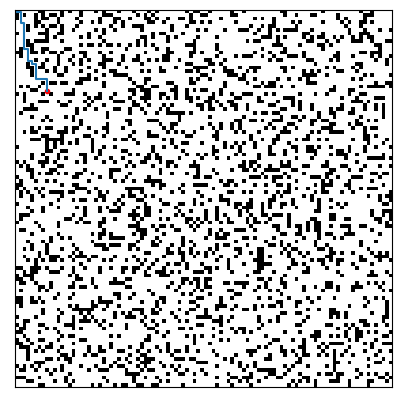

In [ ]:
    lab = generate_random_problem(100, 0.25)
    plt.figure(figsize=(5, 5), dpi=100)
    plot_labirynth(lab)

    aSolver = DijkstraSolver()
    pth = aSolver.solve_problem(lab)

    plot_path(pth)
    plt.show()

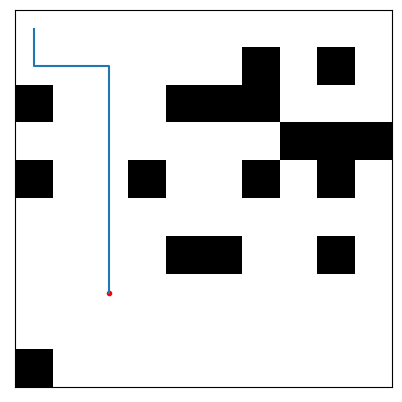

(array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 1, 1, 0, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), array([[7, 2]]), array([[0, 0],
        [1, 0],
        [1, 1],
        [1, 2],
        [2, 2],
        [3, 2],
        [4, 2],
        [5, 2],
        [6, 2],
        [7, 2]], dtype=int32))

In [ ]:
    lab = generate_random_problem(10, 0.2)
    plt.figure(figsize=(5, 5), dpi=100)
    plot_labirynth(lab)

    aSolver = DijkstraSolver()
    pth = aSolver.solve_problem(lab)

    plot_path(pth)
    plt.show()

    lab.labirynth, lab.finish_position, pth

In [ ]:
class DijkstraSolverTestCase(unittest.TestCase):
    def basicMapSuccess(self):
        labirynth = np.array([[1, 0, 1, 0, 1 ], 
                              [1, 0, 0, 0, 0 ], 
                              [1, 1, 1, 1, 1 ], 
                              [0, 0, 0, 0, 0 ], 
                              [1, 1, 1, 1, 1 ]])
        finish = np.array([[2, 4]])
        problem = Labirynth_Problem(labirynth, finish)

        dSolver = DijkstraSolver()
        solution = dSolver.solve_problem(problem)
        expected = np.array([[0, 0],
                             [1, 0],
                             [2, 0],
                             [2, 1],
                             [2, 2],
                             [2, 3],
                             [2, 4]])
        self.assertEqual(np.array_equal(solution, expected), True)

    def startIsMeta(self):
        labirynth = np.array([[1, 0, 1, 0, 1 ], 
                              [1, 0, 0, 0, 0 ], 
                              [1, 1, 1, 1, 1 ], 
                              [0, 0, 0, 0, 0 ], 
                              [1, 1, 1, 1, 1 ]])
        finish = np.array([[0, 0]])
        problem = Labirynth_Problem(labirynth, finish)

        dSolver = DijkstraSolver()
        solution = dSolver.solve_problem(problem)
        expected = np.array([[0, 0]])
        self.assertEqual(np.array_equal(solution, expected), True)

    def noPath(self):
        labirynth = np.array([[1, 0, 1, 0, 1 ], 
                              [1, 0, 0, 0, 0 ], 
                              [1, 1, 1, 0, 1 ], 
                              [0, 0, 0, 0, 0 ], 
                              [1, 1, 1, 1, 1 ]])
        finish = np.array([[2, 4]])
        problem = Labirynth_Problem(labirynth, finish)

        dSolver = DijkstraSolver()
        solution = dSolver.solve_problem(problem)
        expected = np.array([[-1, -1]])
        self.assertEqual(np.array_equal(solution, expected), True)

def suite():
    suite = unittest.TestSuite()
    suite.addTest(DijkstraSolverTestCase('basicMapSuccess'))
    suite.addTest(DijkstraSolverTestCase('startIsMeta'))
    suite.addTest(DijkstraSolverTestCase('noPath'))
    return suite

if __name__ == '__main__':
    runner = unittest.TextTestRunner()
    runner.run(suite())

...
----------------------------------------------------------------------
Ran 3 tests in 0.020s

OK


Algorytm Floyda Warshalla

In [ ]:
class FloydWarshallSolver(Labirynth_Solver):
  INF = 999999

  def solve_problem(self, problem: Labirynth_Problem)-> np.ndarray:
    self.n = problem.size
    self.N = self.n * self.n
    self.initTabs()
    self.addEdges(problem.labirynth)
    self.floydWarshall()
    finish = problem.finish_position[0, 0] * self.n + problem.finish_position[0, 1]
    self.steps = []
    self.isPath = True
    self.generatePath(0, finish)
    self.generateSolution()
    return self.solution

  def initTabs(self):
    self.dist = np.full((self.N, self.N), self.INF)
    for i in range(self.N):
      self.dist[i, i] = 0
    self.p = np.full((self.N, self.N), -1)

  def addEdges(self, labirynth: np.ndarray):
    for i in range(self.n):
      for j in range(self.n):
        #field (i, j) has no obstacle
        if (labirynth[i, j] == 1):
          current = i * self.n + j
          #field on the right from (i, j) has no obstacle
          if (j < self.n - 1 and labirynth[i, j + 1] == 1):
            right = current + 1
            self.dist[current, right] = 1
            self.p[current, right] = current
            self.dist[right, current] = 1
            self.p[right, current] = right
          #field at the bottom form (i, j) has no obstacle
          if (i < self.n - 1 and labirynth[i + 1, j] == 1):
            down = current + self.n
            self.dist[current, down] = 1
            self.p[current, down] = current
            self.dist[down, current] = 1
            self.p[down, current] = down

  def floydWarshall(self):
    for k in range(self.N):
      for i in range(self.N):
        for j in range(self.N):
          if (self.dist[i, k] == self.INF or self.dist[k, j] == self.INF):
            continue
          w = self.dist[i, k] + self.dist[k, j]
          if (self.dist[i, j] > w):
            self.dist[i, j] = w
            self.p[i, j] = self.p[k, j]

  def generatePath(self, start, finish):
    if (start == finish):
      self.steps.append(start)
    elif (self.p[start, finish] == -1):
      self.isPath = False
    else:
      self.generatePath(start, self.p[start, finish])
      self.steps.append(finish)

  def generateSolution(self):
    if (self.isPath == True):
      self.solution = np.empty((len(self.steps), 2), dtype=np.int32)
      for i in range(len(self.steps)):
        a = self.steps[i] // self.n
        b = self.steps[i] % self.n
        self.solution[i, 0] = a
        self.solution[i, 1] = b
    else:
      self.solution = np.array([[-1, -1]])

Algorytm Floyda Warshalla - TESTY

...
----------------------------------------------------------------------
Ran 3 tests in 0.039s

OK


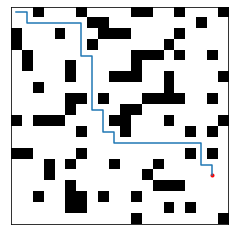

In [ ]:
class FloydWarshallSolverTestCase(unittest.TestCase):
    def basicMapSuccess(self):
        labirynth = np.array([[1, 0, 1, 0, 1 ], 
                              [1, 0, 0, 0, 0 ], 
                              [1, 1, 1, 1, 1 ], 
                              [0, 0, 0, 0, 0 ], 
                              [1, 1, 1, 1, 1 ]])
        finish = np.array([[2, 4]])
        problem = Labirynth_Problem(labirynth, finish)

        fwSolver = FloydWarshallSolver()
        solution = fwSolver.solve_problem(problem)
        expected = np.array([[0, 0],
                             [1, 0],
                             [2, 0],
                             [2, 1],
                             [2, 2],
                             [2, 3],
                             [2, 4]])
        self.assertEqual(np.array_equal(solution, expected), True)

    def startIsMeta(self):
        labirynth = np.array([[1, 0, 1, 0, 1 ], 
                              [1, 0, 0, 0, 0 ], 
                              [1, 1, 1, 1, 1 ], 
                              [0, 0, 0, 0, 0 ], 
                              [1, 1, 1, 1, 1 ]])
        finish = np.array([[0, 0]])
        problem = Labirynth_Problem(labirynth, finish)

        fwSolver = FloydWarshallSolver()
        solution = fwSolver.solve_problem(problem)
        expected = np.array([[0, 0]])
        self.assertEqual(np.array_equal(solution, expected), True)

    def noPath(self):
        labirynth = np.array([[1, 0, 1, 0, 1 ], 
                              [1, 0, 0, 0, 0 ], 
                              [1, 1, 1, 0, 1 ], 
                              [0, 0, 0, 0, 0 ], 
                              [1, 1, 1, 1, 1 ]])
        finish = np.array([[2, 4]])
        problem = Labirynth_Problem(labirynth, finish)

        fwSolver = FloydWarshallSolver()
        solution = fwSolver.solve_problem(problem)
        expected = np.array([[-1, -1]])
        self.assertEqual(np.array_equal(solution, expected), True)

def suite():
    suite = unittest.TestSuite()
    suite.addTest(FloydWarshallSolverTestCase('basicMapSuccess'))
    suite.addTest(FloydWarshallSolverTestCase('startIsMeta'))
    suite.addTest(FloydWarshallSolverTestCase('noPath'))
    return suite

if __name__ == '__main__':
    runner = unittest.TextTestRunner()
    runner.run(suite())

lab = generate_random_problem(20,0.2)
lab.finish_position = np.array([[15,18]])
lab.labirynth[15,18] = 1

fw = FloydWarshallSolver()
path = fw.solve_problem(lab)

plot_labirynth(lab)
plot_path(path)

Algorytm A*

In [ ]:
class AStarSolver(Labirynth_Solver):
    def __init__(self):
        pass

    def reconstruct_path(self, came_from: np.ndarray, current_node, result : []) -> np.array:
        if came_from[current_node[0], current_node[1]][0] != -1:
            self.reconstruct_path(came_from, came_from[current_node[0], current_node[1]], result)
            result.append(current_node)
            return
        else:
            return[]

    def solve_problem(self, problem: Labirynth_Problem) -> np.ndarray:
        INF = 1_000_000

        usedVertices = []  # Set of used vertices 
        unUsedVertices = [(0, 0)]  # set of unused vertices, adjacent to used vertices

        # arrays filled with max int value, vertex distance estimation from start vertex
        g_score = np.full((problem.size, problem.size), INF)
        h_score = np.full((problem.size, problem.size), INF)
        f_score = np.full((problem.size, problem.size), INF)

        g_score[0, 0] = 0  # path from start to current vertex - cost estimation
        f_score[0, 0] = 0
        h_score[0, 0] = 0

        value = np.empty((), dtype=object)
        value[()] = (-1, -1)
        came_from = np.full((problem.size, problem.size), value, dtype=object)

        neighbors = []

        while len(unUsedVertices) != 0:
            # vertex form unUsedVertices with the least value of f(x)
            unUsedVertices = sorted(unUsedVertices, key=lambda v: f_score[v[0], v[1]], reverse=False)
            x = unUsedVertices.pop(0)

            if x[0] == problem.finish_position[0, 0] and x[1] == problem.finish_position[0, 1]:
                result = [(0, 0)]
                self.reconstruct_path(came_from, problem.finish_position[0], result)
                result = [np.array(elem) for elem in result]
                result = np.vstack(result)
                return result

            usedVertices.append(x)
            neighbors = []

            # add all nieghbours of x which are not obstacles
            if x[0] - 1 >= 0 and problem.labirynth[x[0] - 1, x[1]] == 1:
                neighbors.append((x[0] - 1, x[1]))
            if x[0] + 1 <= problem.size - 1 and problem.labirynth[x[0] + 1, x[1]] == 1:
                neighbors.append((x[0] + 1, x[1]))
            if x[1] - 1 >= 0 and problem.labirynth[x[0], x[1] - 1] == 1:
                neighbors.append((x[0], x[1] - 1))
            if x[1] + 1 <= problem.size - 1 and problem.labirynth[x[0], x[1] + 1] == 1:
                neighbors.append((x[0], x[1] + 1))

            for y in neighbors:
                if y in usedVertices:
                    continue

                actual_g_score = g_score[x[0], x[1]] + abs(y[0] - x[0]) + abs(y[1] - x[1])
                is_better = False

                if y not in unUsedVertices:
                    unUsedVertices.append(y)
                    h_score[y[0], y[1]] = abs(problem.finish_position[0, 0] - y[0]) + abs(problem.finish_position[0, 1] - y[1])
                    # print("h_score\n", h_score)
                    is_better = True
                elif actual_g_score < g_score[y[0], y[1]]:
                    is_better = True

                if is_better:
                    came_from[y[0], y[1]] = x
                    # print("Came from \n", came_from)
                    g_score[y[0], y[1]] = actual_g_score
                    # print("g_score \n", g_score)
                    f_score[y[0], y[1]] = g_score[y[0], y[1]] + h_score[y[0], y[1]]  #  Estimated distance from start to goal across y
                    # print("f_score \n", f_score)
        return np.array([[-1,-1]])

Algorytm A* - testy

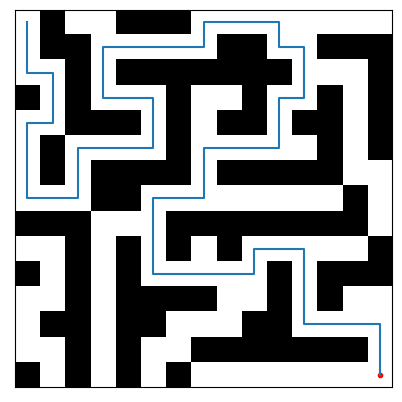

In [ ]:
    #Test 1 
    maze = np.array([
            [1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0],
            [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
            [0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0],
            [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0],
            [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0],
            [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
            [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
            [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0],
            [0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0],
            [1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1],
            [1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1],
            [1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
            [0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]])
    
    finish_position = np.array([[14, 14]])
    lab = Labirynth_Problem(maze, finish_position)
    

    plt.figure(figsize=(5, 5), dpi=100)
    plot_labirynth(lab)

    aSolver = AStarSolver()
    pth = aSolver.solve_problem(lab)

    plot_path(pth)



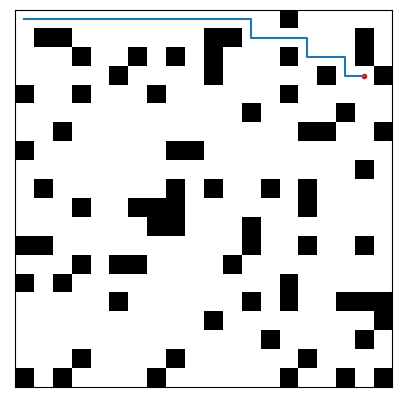

In [ ]:
    #Test 2
    lab = generate_random_problem(20, 0.15)

    plt.figure(figsize=(5, 5), dpi=100)
    plot_labirynth(lab)

    aSolver = AStarSolver()
    pth = aSolver.solve_problem(lab)

    plot_path(pth)
    

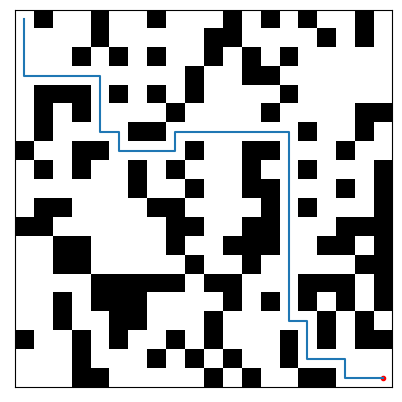

In [ ]:
   #Test 3
    random_problem = np.array([
		[1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1],
		[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1],
		[1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1],
		[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1],
		[1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
		[1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0],
		[1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1],
		[0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1],
		[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0],
		[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0],
		[1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0],
		[0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0],
		[1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0],
		[1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0],
		[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0],
		[1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
		[1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
		[0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0],
		[1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
		[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1]])

    finish_position = np.array([[19, 19]])
    lab = Labirynth_Problem(random_problem, finish_position)
    

    plt.figure(figsize=(5, 5), dpi=100)
    plot_labirynth(lab)

    aSolver = AStarSolver()
    pth = aSolver.solve_problem(lab)

    plot_path(pth)

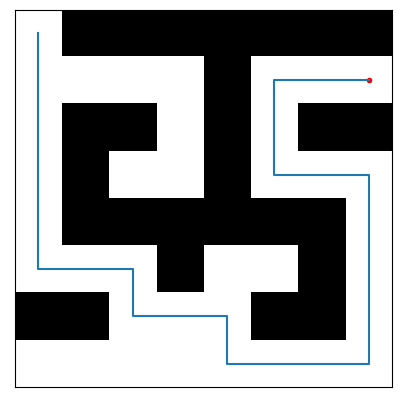

In [ ]:
#Test 4
labirynth = np.array([
        [1,0,0,0,0,0,0,0],
        [1,1,1,1,0,1,1,1],
        [1,0,0,1,0,1,0,0],
        [1,0,1,1,0,1,1,1],
        [1,0,0,0,0,0,0,1],
        [1,1,1,0,1,1,0,1],
        [0,0,1,1,1,0,0,1],
        [1,1,1,1,1,1,1,1]])
    
finish_position = np.array([[1, 7]])
lab = Labirynth_Problem(labirynth, finish_position)


plt.figure(figsize=(5, 5), dpi=100)
plot_labirynth(lab)

aSolver = AStarSolver()
pth = aSolver.solve_problem(lab)

plot_path(pth)

### Algorytm genetyczny

---


In [ ]:
from enum import Enum
class Direction(Enum):
  RIGHT = (0,1)
  DOWN = (1,0)
  LEFT = (0,-1)
  UP =(-1,0)

Reprezentacja pojedynczego chromosomu 

In [ ]:
class Individual:
  def __init__(self, genes: List[Direction] = None, fitness_value: float = 0):
    self.genes = [] if genes is None else genes
    self.fitness_value = fitness_value
    self.solution = self.get_solution()

  def get_solution(self) -> np.array:
    ret = np.zeros((len(self.genes)+1,2), dtype=int)
    for i in range(1,len(self.genes)+1):
      ret[i] = ret[i-1]+self.genes[i-1].value
    return ret

  def clone(self):
    cloned = Individual(list(self.genes), self.fitness_value)
    return cloned

  def __gt__(self, individual):
    return self.fitness_value > individual.fitness_value
  def __lt__(self, individual):
    return self.fitness_value < individual.fitness_value

  @staticmethod
  def create_random_individual(chromosome_length: int):
    dir_list = list(Direction)
    ret = Individual()
    for i in range(chromosome_length):
      ret.genes.append(random.choice(dir_list))
    ret.solution = ret.get_solution()
    return ret

Populacja i inicjalizacja populacji

In [ ]:
class Population:
    def __init__(self, members:List[Individual] = []):
      self.members = members

    def GetAverageFitness(self) -> float:
        cummulative = 0
        for i in self.members:
            cummulative = cummulative + i.fitness_value
        return cummulative/len(self.members)
        
    def GetBestMember(self) -> Individual:
        return max(self.members)


In [ ]:
class PopulationInitializer:
  def initialize_population(self, pop_size:int, max_chromosome_length:int) -> Population:
    pass

class RandomPopulationInitializer(PopulationInitializer):
  def initialize_population(self, pop_size: int, max_chromosome_length: int) -> Population:
    pop = []
    for i in range(pop_size):
      r = np.random.randint(1,max_chromosome_length)
      pop.append(Individual.create_random_individual(r))
    return Population(pop)

class NoObstaclesPopulationInitializer(PopulationInitializer):
    def __init__(self, problem: Labirynth_Problem):
      self.problem = problem

    def initialize_population(self, pop_size: int, max_chromosome_length: int) -> Population:
      pop = []
      dir_list = list(Direction)
      for i in range(pop_size):
        curr_genes = []
        curr_pos = np.zeros((1,2), dtype=int)
        r = np.random.randint(1,max_chromosome_length)
        for j in range(r):
          x = np.random.choice(dir_list, size = 4, replace = False)
          to_add = x[0]
          for k in range(1,4):
            if self.__check_position(curr_pos+to_add.value, self.problem):
              break
            to_add = x[k]
          curr_genes.append(to_add)
          curr_pos = curr_pos + to_add.value
        pop.append(Individual(curr_genes))
      return Population(pop)

    def __check_position(self, pos: np.array, problem: Labirynth_Problem) -> bool:
      if pos[0][0] < 0 or pos[0][0] >= problem.size or pos[0][1] < 0 or pos[0][1] >= problem.size:
        return False
      if problem.labirynth[pos[0][0]][pos[0][1]] == 0:
        return False
      return True

class OnionPopulationInitializer(PopulationInitializer):
    def __init__(self, finish_point): # start_point = 0,0
      self.finish_point = finish_point

    def initialize_population(self, pop_size: int, chromosome_length: int) -> Population:
      steps_right = self.finish_point[0]
      steps_up = self.finish_point[1]
      pop = []

      for i in range((int)(pop_size/10)):
        genes = [Direction.DOWN] * steps_up + [Direction.RIGHT] * steps_right
        np.random.shuffle(genes)    
        ind = Individual(genes)
        pop.append(ind)
      for i in range((int)(9*pop_size/10)):
        pop.append(Individual.create_random_individual(chromosome_length))
      return Population(pop)


Reprodukcja

In [ ]:
class Reproduction:
  def Reproduce(self, population: Population) -> List[List[Individual]]:
    pass

class Roulette_Reproduction(Reproduction):
  def Reproduce(self, population: Population) -> List[List[Individual]]:
    fitness_sum = sum([x.fitness_value for x in population.members])
    choose_probability = [x.fitness_value/fitness_sum for x in population.members]
    return list(np.random.choice(population.members, (int(len(population.members)/2),2), True, choose_probability))

class Tournament_Reproduction(Reproduction):
  def __init__(self, k: int = 10):
    self.k = k

  def Reproduce(self, population: Population) -> List[List[Individual]]:
    ret = []
    for i in range(int(len(population.members)/2)):
      p1, p2 = np.random.choice(population.members, self.k, False), np.random.choice(population.members, self.k, False)
      ret.append([max(p1),max(p2)])
    return ret

Funkcja dopasowania

In [ ]:
def Compute_fitness(individual: Individual,
                    problem: Labirynth_Problem,
                    dist_pen=1,
                    obst_pen=1,
                    path_len_pen=0.01):
    last_point = individual.solution[-1]
    distance_to_finish = \
    abs(problem.finish_position[0,0]-last_point[0]) + \
    abs(problem.finish_position[0,1]-last_point[1])
    obstacles = 0
    for p in individual.solution:
        if (p[0] < 0 or p[1] < 0 or
        p[0] >= problem.size or p[1] >= problem.size):
            obstacles = obstacles + 1
        elif problem.labirynth[p[0],p[1]] == 0:
            obstacles = obstacles + 1
    individual.fitness_value = 1/(dist_pen*distance_to_finish + obst_pen*obstacles + path_len_pen*len(individual.solution) + 1)

Operatory krzyżowania

In [ ]:
def cross_op(individual1: Individual, individual2: Individual) -> List[Individual]:
    cut_point = np.random.randint(0, min(len(individual1.genes), len(individual2.genes)))
    child1 = Individual(individual1.genes[:cut_point] + individual2.genes[cut_point:])
    child2 = Individual(individual2.genes[:cut_point] + individual1.genes[cut_point:])
    return [child1, child2]

In [ ]:
def cross_op_multipoints(individual1: Individual, individual2: Individual) -> List[Individual]:
    if min(len(individual1.genes), len(individual2.genes)) >=3 :
      cut_point1 = np.random.randint(0, min(len(individual1.genes), len(individual2.genes))/3)
      cut_point2 = np.random.randint(min(len(individual1.genes), len(individual2.genes))/3, 2*min(len(individual1.genes), len(individual2.genes))/3)
      cut_point3 = np.random.randint(2*min(len(individual1.genes), len(individual2.genes))/3, min(len(individual1.genes), len(individual2.genes)))
      child1 = Individual(individual1.genes[:cut_point1] + individual2.genes[cut_point1:cut_point2] + individual1.genes[cut_point2:cut_point3])
      child2 = Individual(individual2.genes[:cut_point1] + individual1.genes[cut_point1:cut_point2] + individual2.genes[cut_point2:cut_point3])
      return [child1, child2]
    else:
      cut_point = np.random.randint(0, min(len(individual1.genes), len(individual2.genes)))
      child1 = Individual(individual1.genes[:cut_point] + individual2.genes[cut_point:])
      child2 = Individual(individual2.genes[:cut_point] + individual1.genes[cut_point:])
      return [child1, child2]

Operator mutacji

In [ ]:
def mutation_op(individual: Individual):
    r = np.random.randint(0,len(individual.genes))
    individual.genes[r] = np.random.choice(list(Direction),1)[0]
    individual.solution = individual.get_solution()

Generowanie nowej populacji na podstawie populacji bazowej (reporodukcja + operatory)

In [ ]:
def GenerateNewGeneration(pop: Population,
                          problem: Labirynth_Problem,
                          cross_prob,
                          mutation_prob,
                          reproduction,
                          save_best)-> Population:
    temp_pop = reproduction.Reproduce(pop)
    children = []
    r = np.random.rand(1)
    for i in temp_pop:
        if r < cross_prob:
          children = children + cross_op(i[0],i[1])
        else:
          children = children + [i[0],i[1]]
    
    for c in np.random.choice(children,int(len(children)/(1/mutation_prob))):
        mutation_op(c)
    if save_best:
      children[np.random.randint(0,len(children))] = pop.GetBestMember()
    new_pop = Population(children)

    return new_pop

Główna pętla algorytmu genetycznego

In [ ]:
def SolveProblem(problem: Labirynth_Problem,
                 pop_size = 1000,
                 max_iter = 1000,
                 cross_prob = 0.95,
                 mutation_prob = 0.2,
                 dist_pen = 1,
                 obst_pen = 1,
                 path_len_pen = 0.01,
                 reproduction = Roulette_Reproduction(),
                 save_best = False,
                 stop_K = 10,
                 stop_alpha = 0.01
                 ):
  init = RandomPopulationInitializer()
  pop = init.initialize_population(pop_size,problem.size**2)
  for i in pop.members:
    #Compute_fitness(i,lab,dist_pen,obst_pen,path_len_pen)
    Compute_fitness(i, problem, dist_pen, obst_pen, path_len_pen)
  curr_best_fitness = pop.GetBestMember().fitness_value
  iter_count = 0
  no_improvement_count = 0

  while iter_count < max_iter:
    #new_pop = GenerateNewGeneration(pop, lab,cross_prob,mutation_prob,reproduction,save_best)
    new_pop = GenerateNewGeneration(pop, problem, cross_prob, mutation_prob, reproduction, save_best)

    for i in new_pop.members:
      Compute_fitness(i, problem, dist_pen, obst_pen, path_len_pen)
      
    pop = new_pop
    no_improvement_count = no_improvement_count + 1

    if pop.GetBestMember().fitness_value - curr_best_fitness >= stop_alpha:
      curr_best_fitness = pop.GetBestMember().fitness_value
      no_improvement_count = 0
    else: 
      if no_improvement_count >= stop_K:
        break
    iter_count = iter_count + 1

    #print(iter_count)
    #print("Average fitness: " + str(new_pop.GetAverageFitness())+"   Best fitness: "+str(new_pop.GetBestMember().fitness_value))
  
  return pop.GetBestMember().solution



In [ ]:
class GeneticSolver(Labirynth_Solver):
  def solve_problem(self, problem: Labirynth_Problem) -> np.ndarray:
    return SolveProblem(problem, 1000)

## Algorytm genetyczny a algorytmy planowania - przykładowe testy z wizualizacją 

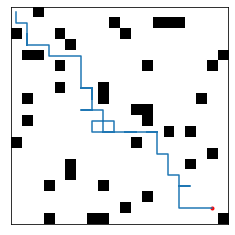

In [ ]:
# in the third test its better for 3000 population memebers, stop_K=40, stop_alpha = 0.005, while in the below smaller values are better

lab1 = generate_random_problem(20,0.1)
lab1.finish_position = np.array([[18,18]])

g = GeneticSolver()
pop = g.solve_problem(lab1)

plot_labirynth(lab1)
plot_path(pop)

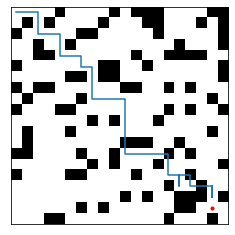

In [ ]:
lab2 = generate_random_problem(20,0.23)
lab2.finish_position = np.array([[18, 18]])

g = GeneticSolver()
pop = g.solve_problem(lab2)

plot_labirynth(lab2)
plot_path(pop)

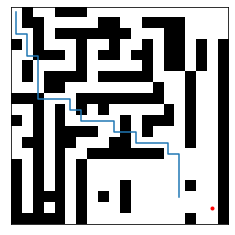

In [ ]:
# to increase precision: call for 3000 population memebers, stop_K=40, stop_alpha = 0.005

maze = np.array([
    [1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1],
    [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1],
    [0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0],
    [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0],
    [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0],
    [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
    [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0],
    [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0],
    [0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0],
    [1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0],
    [1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0],
    [1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0],
    [0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0],
    [0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0]])

finish_position = np.array([[18, 18]])
lab3 = Labirynth_Problem(maze,finish_position)

g = GeneticSolver()
pop = g.solve_problem(lab3)

plot_labirynth(lab3)
plot_path(pop)

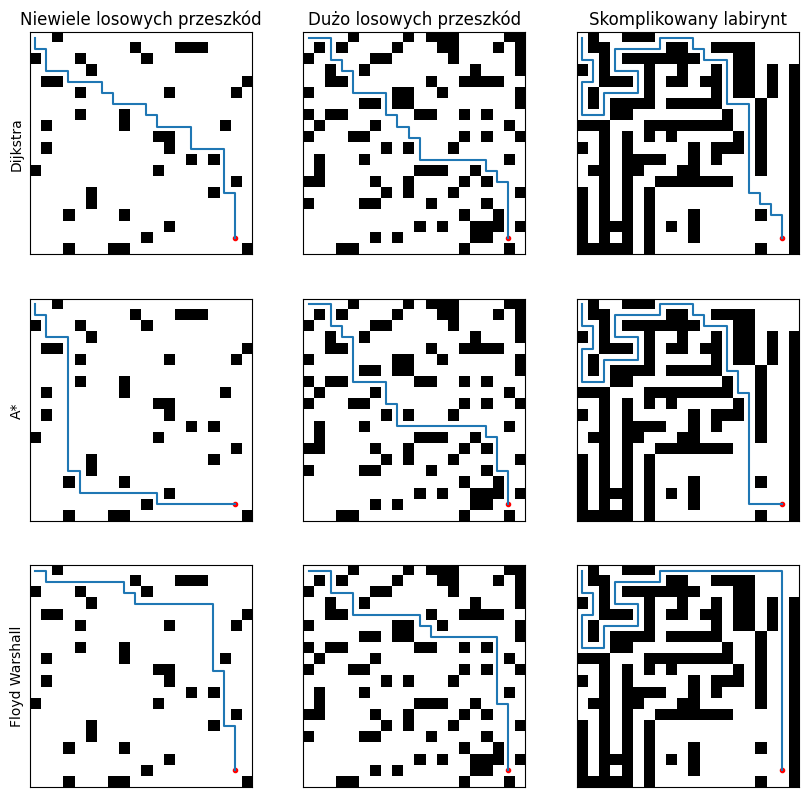

In [ ]:
# planning algorithms

solvers = [DijkstraSolver(),AStarSolver(),FloydWarshallSolver()]

def ax_plot_population(population,ax) -> None:
  for i in range(len(population.members)):
    curr_path = population.members[i].get_solution()
    ax.plot(curr_path[:,1], curr_path[:,0]) 

def draw():
  fig = plt.figure(figsize=(10, 10), dpi=100)
  for i in range(0, len(solvers)):

      aSolver = solvers[i]
      ax = fig.add_subplot(3, 3, i*3 +1)
      if i == 0:
          ax.set_ylabel('Dijkstra')
      if i == 1:
          ax.set_ylabel('A*')
      if i == 2:
          ax.set_ylabel('Floyd Warshall')

      # 1
      ax.imshow(lab1.labirynth, cmap="gray")
      ax.plot(lab1.finish_position[0, 1], lab1.finish_position[0, 0], "r.")
      ax.set_xticks([])
      ax.set_yticks([])
      pth = aSolver.solve_problem(lab1)
      if pth[0, 0] != -1:
          ax.plot(pth[:, 1], pth[:, 0])
      if i == 0:
          ax.set_title("Niewiele losowych przeszkód")

      # 2
      ax = fig.add_subplot(3, 3, i*3 +2)
      ax.imshow(lab2.labirynth, cmap="gray")
      ax.plot(lab2.finish_position[0, 1], lab2.finish_position[0, 0], "r.")
      ax.set_xticks([])
      ax.set_yticks([])
      pth = aSolver.solve_problem(lab2)
      if pth[0, 0] != -1:
          ax.plot(pth[:, 1], pth[:, 0])
      if i == 0:
          ax.set_title("Dużo losowych przeszkód")

      # 3
      ax = fig.add_subplot(3, 3, i*3 +3)
      ax.imshow(lab3.labirynth, cmap="gray")
      ax.plot(lab3.finish_position[0, 1], lab3.finish_position[0, 0], "r.")
      ax.set_xticks([])
      ax.set_yticks([])    
      pth = aSolver.solve_problem(lab3)
      if pth[0, 0] != -1:
          ax.plot(pth[:, 1], pth[:, 0])
      if i == 0:
          ax.set_title("Skomplikowany labirynt")

  plt.show()

draw()

## Testy wydajności

In [ ]:
import random
#Porównanie czasów
def measure_time(solvers: List[Labirynth_Solver],
                 problem_size:int=90,
                 obstacle_rate:float=0.1,
                 number_of_problems:int=10):
  times = [[] for i in range(0,len(solvers))]
  for i in range(0,number_of_problems):
    print(f'Measuring problem {i+1} out of {number_of_problems}.')
    problem = generate_random_problem(problem_size, obstacle_rate)
    for j in range(0,len(solvers)):
      start = time.time()
      solvers[j].solve_problem(problem)
      end = time.time()
      times[j].append(end-start)
  return np.array(times).T


solvers = [GeneticSolver(),DijkstraSolver(),AStarSolver()]
times = measure_time(solvers)

df = pd.DataFrame(times)
df.rename(columns={0: "Genetic", 1: "Dijkstra", 2:"A*"}).describe().loc[["mean","std","min","50%","max"]]

Measuring problem 1 out of 10.
Measuring problem 2 out of 10.
Measuring problem 3 out of 10.
Measuring problem 4 out of 10.
Measuring problem 5 out of 10.
Measuring problem 6 out of 10.
Measuring problem 7 out of 10.
Measuring problem 8 out of 10.
Measuring problem 9 out of 10.
Measuring problem 10 out of 10.


,Genetic,Dijkstra,A*
mean,44.564882,0.672824,0.369377
std,6.950128,0.383957,0.629573
min,33.842338,0.009069,0.000446
50%,43.257821,0.776659,0.103044
max,54.196194,1.167686,2.042032
